**About** : This notebook is used to train models.

References :
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537
- https://www.kaggle.com/c/data-science-bowl-2018/discussion/56326
- https://www.kaggle.com/c/data-science-bowl-2018/discussion/54741


**Models :**

2. DCN -> https://github.com/open-mmlab/mmdetection/tree/master/configs/dcn
3. SCNet ? -> https://github.com/open-mmlab/mmdetection/tree/master/configs/scnet

**TODO :**
- PL trains : 
 - Cascade rx101 freeze + no freeze
 - Cascade r50 nofreeze
 - Cascade b7 freeze

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/kaggle/sartorius/src


## Initialization

### Imports

In [3]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from tqdm.notebook import tqdm
from collections import Counter
warnings.simplefilter("ignore", UserWarning)

In [19]:
from params import *

from utils.plots import *
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data, get_splits, prepare_extra_data, prepare_target
from data.dataset import SartoriusDataset
from data.transforms import get_transfos

from training.main import k_fold
from main_training import BATCH_SIZES

## Data

In [5]:
class Config:
    """
    Parameters used for training
    """
    # Images
    use_mosaic = False
    use_tta = False  # TODO
    data_config = "configs/config_aug_mosaic.py" if use_mosaic else "configs/config_aug.py"
#     data_config = "data/config_rescale.py"

In [6]:
df = prepare_data()

In [7]:
transforms = get_transfos(256, visualize=True)

In [8]:
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,img_path,ann,is_extra,plate,well,plate_well,plate_class
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,../input/train/0030fd0e6378.png,"{'bboxes': [[576, 167, 603, 197], [359, 268, 3...",0,shsy5y[diff],E10,shsy5y[diff]_E10,5
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,../input/train/0140b3c8f445.png,"{'bboxes': [[37, 46, 119, 136], [676, 84, 702,...",0,astros[cereb],F8,astros[cereb]_F8,1
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...,704,520,cort,13h30m00s,2020-11-04,cort[oka-high]_B5-1_Vessel-377_Ph_1,0 days 13:30:00,../input/train/01ae5a43a2ab.png,"{'bboxes': [[248, 342, 264, 363], [445, 405, 4...",0,cort[oka-high],B5,cort[oka-high]_B5,4
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565...,704,520,cort,19h30m00s,2020-11-04,cort[oka-low]_H6-2_Vessel-377_Ph_2,0 days 19:30:00,../input/train/026b3c2c4b32.png,"{'bboxes': [[380, 242, 394, 257], [299, 68, 31...",0,cort[oka-low],H6,cort[oka-low]_H6,2
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955...,704,520,cort,13h30m00s,2020-10-27,cort[pre-treat]_B8-2_Vessel-377_Ph_2,0 days 13:30:00,../input/train/029e5b3b89c7.png,"{'bboxes': [[448, 197, 465, 213], [337, 303, 3...",0,cort[pre-treat],B8,cort[pre-treat]_B8,3


In [9]:
df_extra = prepare_extra_data()

df, df_extra = prepare_target(df, df_extra)

df['target'] = df['target_0']
df_extra['target'] = df_extra['target_0']


In [10]:
transforms = get_transfos(256, visualize=True, augment=False)

In [11]:
Counter(df['target']), Counter(df_extra['target'])

(Counter({1.0: 120, 0.0: 483}), Counter({0.0: 1582, 1.0: 390}))

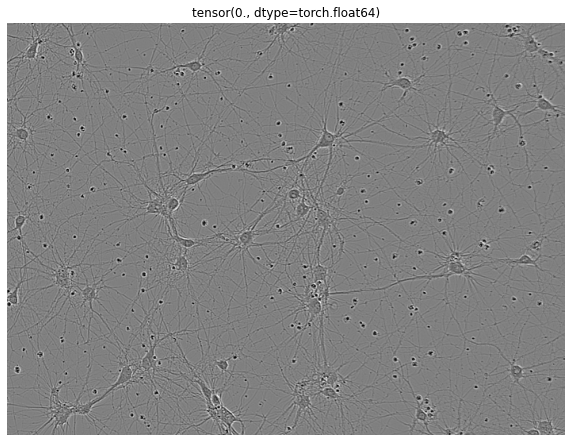

In [12]:
# dataset = SartoriusDataset(df, pipelines['test_viz'], precompute_masks=False)
dataset = SartoriusDataset(df_extra.sample(10), transforms)
# dataset.sample_extra_data(10)
# dataset = SartoriusDataset(df, pipelines['train_viz'], precompute_masks=False)


for idx in range(len(dataset)):
    idx = np.random.choice(len(dataset))
    img, y = dataset[idx]
    
    img = img.cpu().numpy().transpose(1, 2, 0)
    

    plt.figure(figsize=(10, 10))
    plot_sample(img)
    plt.title(y)
    plt.axis(False)
    plt.show()
    
    break

## Training

In [63]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 0
    compute_val_loss = False
    verbose_eval = 5

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    fix = True
    remove_anomalies = True
    size = 256

    extra_name = ""
    use_pl = False

    # k-fold
    split = "gkf"
    k = 5
    random_state = 0
    selected_folds = [0] # , 1, 2, 3, 4]

    # Model
    encoder = "resnet18"
    freeze_bn = False
    num_classes = 1

    # Training
    optimizer = "Adam"
    scheduler = "linear"
    weight_decay = 0
    batch_size = 16
    val_bs = batch_size

    epochs = 30

    lr = 1e-4
    warmup_prop = 0.05

    use_fp16 = False  # TODO

In [64]:
DEBUG = True
log_folder = None

In [65]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder)
    create_logger(directory=log_folder, name="logs.txt")

preds = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 603 training images
    -> 1972 validation images
    -> 11690025 trainable parameters



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/30 	 lr=6.6e-05	 t=2s	loss=1.236
Epoch 02/30 	 lr=9.8e-05	 t=2s	loss=1.173
Epoch 03/30 	 lr=9.5e-05	 t=2s	loss=1.129
Epoch 04/30 	 lr=9.1e-05	 t=2s	loss=1.032
Epoch 05/30 	 lr=8.8e-05	 t=11s	loss=1.014	 avg_val_loss=1.050	 acc=0.573
Epoch 06/30 	 lr=8.5e-05	 t=2s	loss=1.069
Epoch 07/30 	 lr=8.1e-05	 t=2s	loss=1.016
Epoch 08/30 	 lr=7.8e-05	 t=2s	loss=1.061
Epoch 09/30 	 lr=7.4e-05	 t=2s	loss=0.957
Epoch 10/30 	 lr=7.1e-05	 t=11s	loss=0.859	 avg_val_loss=1.038	 acc=0.683
Epoch 11/30 	 lr=6.7e-05	 t=2s	loss=0.859
Epoch 12/30 	 lr=6.4e-05	 t=2s	loss=0.833
Epoch 13/30 	 lr=6.0e-05	 t=2s	loss=0.834
Epoch 14/30 	 lr=5.7e-05	 t=2s	loss=0.799
Epoch 15/30 	 lr=5.4e-05	 t=11s	loss=0.800	 avg_val_loss=0.958	 acc=0.758
Epoch 16/30 	 lr=5.0e-05	 t=2s	loss=0.773
Epoch 17/30 	 lr=4.7e-05	 t=2s	loss=0.765
Epoch 18/30 	 lr=4.3e-05	 t=2s	loss=0.765
Epoch 19/30 	 lr=4.0e-05	 t=2s	loss=0.668
Epoch 20/30 	 lr=3.6e-05	 t=11s	loss=0.671	 avg_val_loss=0.989	 acc=0.797
Epoch 21/30 	 lr=3.3e-05	 t=2s	l

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/30 	 lr=6.6e-05	 t=2s	loss=1.234
Epoch 02/30 	 lr=9.8e-05	 t=2s	loss=1.188
Epoch 03/30 	 lr=9.5e-05	 t=2s	loss=1.200
Epoch 04/30 	 lr=9.1e-05	 t=2s	loss=1.101
Epoch 05/30 	 lr=8.8e-05	 t=11s	loss=1.113	 avg_val_loss=1.197	 acc=0.634
Epoch 06/30 	 lr=8.5e-05	 t=2s	loss=1.025
Epoch 07/30 	 lr=8.1e-05	 t=2s	loss=1.059
Epoch 08/30 	 lr=7.8e-05	 t=2s	loss=1.044
Epoch 09/30 	 lr=7.4e-05	 t=2s	loss=1.011
Epoch 10/30 	 lr=7.1e-05	 t=11s	loss=1.005	 avg_val_loss=1.090	 acc=0.632
Epoch 11/30 	 lr=6.7e-05	 t=2s	loss=1.018
Epoch 12/30 	 lr=6.4e-05	 t=2s	loss=0.959
Epoch 13/30 	 lr=6.0e-05	 t=2s	loss=0.914
Epoch 14/30 	 lr=5.7e-05	 t=2s	loss=1.032
Epoch 15/30 	 lr=5.4e-05	 t=11s	loss=0.951	 avg_val_loss=1.035	 acc=0.646
Epoch 16/30 	 lr=5.0e-05	 t=2s	loss=0.882
Epoch 17/30 	 lr=4.7e-05	 t=2s	loss=0.872
Epoch 18/30 	 lr=4.3e-05	 t=2s	loss=0.861
Epoch 19/30 	 lr=4.0e-05	 t=2s	loss=0.839
Epoch 20/30 	 lr=3.6e-05	 t=11s	loss=0.866	 avg_val_loss=1.027	 acc=0.680
Epoch 21/30 	 lr=3.3e-05	 t=2s	l

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/30 	 lr=6.6e-05	 t=2s	loss=1.274
Epoch 02/30 	 lr=9.8e-05	 t=2s	loss=1.109
Epoch 03/30 	 lr=9.5e-05	 t=2s	loss=1.302
Epoch 04/30 	 lr=9.1e-05	 t=2s	loss=0.998
Epoch 05/30 	 lr=8.8e-05	 t=11s	loss=0.959	 avg_val_loss=1.225	 acc=0.711
Epoch 06/30 	 lr=8.5e-05	 t=2s	loss=0.914
Epoch 07/30 	 lr=8.1e-05	 t=2s	loss=0.887
Epoch 08/30 	 lr=7.8e-05	 t=2s	loss=0.834
Epoch 09/30 	 lr=7.4e-05	 t=2s	loss=0.853
Epoch 10/30 	 lr=7.1e-05	 t=11s	loss=0.869	 avg_val_loss=1.049	 acc=0.635
Epoch 11/30 	 lr=6.7e-05	 t=2s	loss=0.850
Epoch 12/30 	 lr=6.4e-05	 t=2s	loss=0.709
Epoch 13/30 	 lr=6.0e-05	 t=2s	loss=0.711
Epoch 14/30 	 lr=5.7e-05	 t=2s	loss=0.721
Epoch 15/30 	 lr=5.4e-05	 t=11s	loss=0.771	 avg_val_loss=1.028	 acc=0.784
Epoch 16/30 	 lr=5.0e-05	 t=2s	loss=0.699
Epoch 17/30 	 lr=4.7e-05	 t=2s	loss=0.631
Epoch 18/30 	 lr=4.3e-05	 t=2s	loss=0.652
Epoch 19/30 	 lr=4.0e-05	 t=2s	loss=0.623
Epoch 20/30 	 lr=3.6e-05	 t=11s	loss=0.627	 avg_val_loss=0.983	 acc=0.744
Epoch 21/30 	 lr=3.3e-05	 t=2s	l

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/30 	 lr=6.6e-05	 t=2s	loss=1.233
Epoch 02/30 	 lr=9.8e-05	 t=2s	loss=1.038
Epoch 03/30 	 lr=9.5e-05	 t=2s	loss=1.019
Epoch 04/30 	 lr=9.1e-05	 t=2s	loss=0.885
Epoch 05/30 	 lr=8.8e-05	 t=11s	loss=0.904	 avg_val_loss=1.065	 acc=0.580
Epoch 06/30 	 lr=8.5e-05	 t=2s	loss=0.828
Epoch 07/30 	 lr=8.1e-05	 t=2s	loss=0.900
Epoch 08/30 	 lr=7.8e-05	 t=2s	loss=0.933
Epoch 09/30 	 lr=7.4e-05	 t=2s	loss=0.824
Epoch 10/30 	 lr=7.1e-05	 t=11s	loss=0.792	 avg_val_loss=0.981	 acc=0.653
Epoch 11/30 	 lr=6.7e-05	 t=2s	loss=0.856
Epoch 12/30 	 lr=6.4e-05	 t=2s	loss=0.760
Epoch 13/30 	 lr=6.0e-05	 t=2s	loss=0.698
Epoch 14/30 	 lr=5.7e-05	 t=2s	loss=0.712
Epoch 15/30 	 lr=5.4e-05	 t=11s	loss=0.698	 avg_val_loss=0.929	 acc=0.759
Epoch 16/30 	 lr=5.0e-05	 t=2s	loss=0.733
Epoch 17/30 	 lr=4.7e-05	 t=2s	loss=0.645
Epoch 18/30 	 lr=4.3e-05	 t=2s	loss=0.746
Epoch 19/30 	 lr=4.0e-05	 t=2s	loss=0.593
Epoch 20/30 	 lr=3.6e-05	 t=11s	loss=0.617	 avg_val_loss=0.880	 acc=0.695
Epoch 21/30 	 lr=3.3e-05	 t=2s	l

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/30 	 lr=6.6e-05	 t=2s	loss=1.215
Epoch 02/30 	 lr=9.8e-05	 t=2s	loss=1.117
Epoch 03/30 	 lr=9.5e-05	 t=2s	loss=0.997
Epoch 04/30 	 lr=9.1e-05	 t=2s	loss=0.967
Epoch 05/30 	 lr=8.8e-05	 t=11s	loss=1.021	 avg_val_loss=1.300	 acc=0.763
Epoch 06/30 	 lr=8.5e-05	 t=2s	loss=0.967
Epoch 07/30 	 lr=8.1e-05	 t=2s	loss=0.827
Epoch 08/30 	 lr=7.8e-05	 t=2s	loss=0.882
Epoch 09/30 	 lr=7.4e-05	 t=2s	loss=0.853
Epoch 10/30 	 lr=7.1e-05	 t=11s	loss=0.879	 avg_val_loss=1.002	 acc=0.614
Epoch 11/30 	 lr=6.7e-05	 t=2s	loss=0.769
Epoch 12/30 	 lr=6.4e-05	 t=2s	loss=0.688
Epoch 13/30 	 lr=6.0e-05	 t=2s	loss=0.708
Epoch 14/30 	 lr=5.7e-05	 t=2s	loss=0.671
Epoch 15/30 	 lr=5.4e-05	 t=11s	loss=0.726	 avg_val_loss=0.946	 acc=0.636
Epoch 16/30 	 lr=5.0e-05	 t=2s	loss=0.628
Epoch 17/30 	 lr=4.7e-05	 t=2s	loss=0.655
Epoch 18/30 	 lr=4.3e-05	 t=2s	loss=0.660
Epoch 19/30 	 lr=4.0e-05	 t=2s	loss=0.729
Epoch 20/30 	 lr=3.6e-05	 t=11s	loss=0.649	 avg_val_loss=1.019	 acc=0.783
Epoch 21/30 	 lr=3.3e-05	 t=2s	l

### Results analysis

 - Fold 0
Acc :  0.756


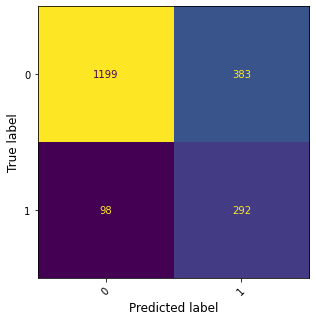

 - Fold 1
Acc :  0.733


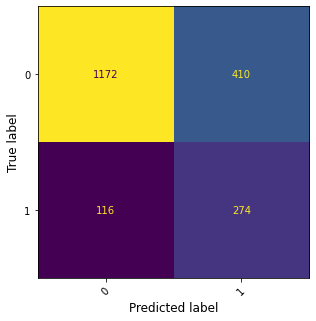

 - Fold 2
Acc :  0.795


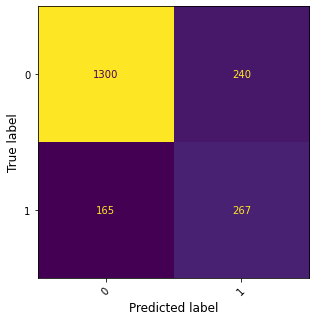

 - Fold 3
Acc :  0.793


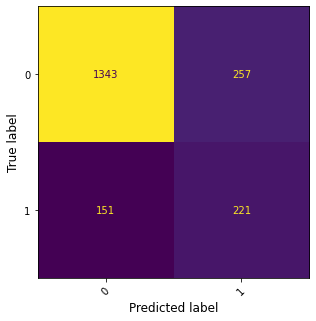

 - Fold 4
Acc :  0.782


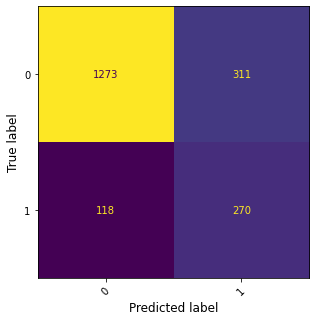

In [73]:
THRESHOLD = 0.5

for i, pred in enumerate(preds):
    print(f' - Fold {i}')
    
#     sns.displot(pred)
#     plt.show()
    
    df_extra[f'pred_{i}'] = pred
    
    print(f"Acc :  {accuracy_score(df_extra[f'pred_{i}'] > THRESHOLD, df_extra[f'target_{i}']) :.3f}")
    
    plt.figure(figsize=(5, 5))
    cm = plot_confusion_matrix(df_extra[f'pred_{i}'] > THRESHOLD, df_extra[f'target_{i}'], display_labels=["0", "1"])
    plt.show()
    
df_extra.to_csv('../output/df_extra_adv.csv', index=False)

In [79]:
df_extra.head()

,id,predicted,img_path,plate,well,plate_well,cell_type,plate_class,is_extra,target_0,...,target_3,target_4,target,pred,pred_,pred_0,pred_1,pred_2,pred_3,pred_4
0,cort[density]_C6-1_Vessel-376_2020-11-03_13h30...,,../input/train_semi_supervised/cort[density]_C...,cort[density],C6,cort[density]_C6,cort,3,1,0.0,...,0.0,0.0,0.0,0.478932,0.088703,0.478932,0.146525,0.046590,0.377002,0.428851
1,cort[density]_B7-2_Vessel-376_2020-11-07_13h30...,,../input/train_semi_supervised/cort[density]_B...,cort[density],B7,cort[density]_B7,cort,3,1,0.0,...,0.0,1.0,0.0,0.042428,0.120636,0.042428,0.132026,0.030504,0.131743,0.962856
2,astro[hippo]_F2-2_Vessel-361_2020-09-15_13h00m...,,../input/train_semi_supervised/astro[hippo]_F2...,astro[hippo],F2,astro[hippo]_F2,astro,0,1,0.0,...,1.0,0.0,0.0,0.180619,0.460779,0.180619,0.576714,0.083281,0.781847,0.010839
3,astro[hippo]_F3-2_Vessel-361_2020-09-14_13h00m...,,../input/train_semi_supervised/astro[hippo]_F3...,astro[hippo],F3,astro[hippo]_F3,astro,0,1,0.0,...,0.0,1.0,0.0,0.696479,0.206334,0.696479,0.250237,0.069578,0.120564,0.585268
4,astros[cereb]_G10-3_Vessel-361_2020-09-14_09h0...,,../input/train_semi_supervised/astros[cereb]_G...,astros[cereb],G10,astros[cereb]_G10,astro,1,1,0.0,...,0.0,0.0,0.0,0.265324,0.364270,0.265324,0.727702,0.210444,0.511305,0.136862


In [77]:
dfg = df_extra[
    ["plate", "pred_0", "pred_1", "pred_2", "pred_3", "pred_4"]
].groupby('plate').mean()
dfg

,pred_0,pred_1,pred_2,pred_3,pred_4
plate,,,,,
astro[hippo],0.346220,0.517771,0.302160,0.347939,0.275082
astros[cereb],0.475142,0.360481,0.368444,0.279394,0.381236
cort[6-OHDA],0.066351,0.133166,0.519137,0.074077,0.531898
cort[debris],0.039462,0.076416,0.016778,0.988973,0.029809
cort[density],0.409098,0.398205,0.212326,0.372345,0.253745
cort[oka-high],0.778101,0.697482,0.013528,0.035614,0.033195
cort[oka-low],0.059054,0.138409,0.167975,0.117236,0.821004
cort[pre-treat],0.139696,0.237425,0.477181,0.548899,0.196624
shsy5y[diff],0.344556,0.307077,0.332140,0.280602,0.399673


In [78]:
dfg = df_extra[
    ["plate_well", "plate", "pred_0", "pred_1", "pred_2", "pred_3", "pred_4", 
     "target_0", "target_1", "target_2", "target_3", "target_4"]
].groupby('plate_well').mean()
dfg

,pred_0,pred_1,pred_2,pred_3,pred_4,target_0,target_1,target_2,target_3,target_4
plate_well,,,,,,,,,,
astro[hippo]_D1,0.221173,0.568764,0.441768,0.344798,0.239652,0.0,1.0,0.0,0.0,0.0
astro[hippo]_D3,0.212727,0.563672,0.400224,0.355128,0.219219,0.0,0.0,1.0,0.0,0.0
astro[hippo]_E2,0.270489,0.601770,0.284730,0.609208,0.038500,0.0,0.0,1.0,0.0,0.0
astro[hippo]_E3,0.544276,0.452055,0.120163,0.453806,0.241480,0.0,0.0,0.0,1.0,0.0
astro[hippo]_F2,0.162344,0.657152,0.211306,0.659351,0.021857,0.0,0.0,0.0,1.0,0.0
astro[hippo]_F3,0.677018,0.271658,0.078774,0.185597,0.605326,0.0,0.0,0.0,0.0,1.0
astro[hippo]_F5,0.716178,0.312541,0.116602,0.118858,0.607229,1.0,0.0,0.0,0.0,0.0
astro[hippo]_G1,0.274522,0.557454,0.449381,0.281960,0.306693,0.0,0.0,0.0,0.0,1.0
astro[hippo]_G2,0.288423,0.523886,0.407224,0.306323,0.233613,1.0,0.0,0.0,0.0,0.0
